In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv
/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip
/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip


In [2]:
files = "/kaggle/working/"

train_path = "/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip"

test_path = "/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip"

import zipfile

with zipfile.ZipFile(train_path, 'r') as zipp:
    zipp.extractall(files)
    
with zipfile.ZipFile(test_path, 'r') as zipp:
    zipp.extractall(files)

In [3]:
import os
import shutil
import pandas as pd

def move_files_class_directory(data_dir, cls, destination_directory):
    files = os.listdir(data_dir)
    
    matching_files = [file for file in files if cls in file]
    
    os.makedirs(destination_directory, exist_ok=True)
    
    for file in matching_files:
        source = os.path.join(data_dir, file)
        destination = os.path.join(destination_directory, file)
        shutil.move(source, destination)

data_dir = "/kaggle/working/train"
cls = "dog"
destination_directory = os.path.join(data_dir, cls)

move_files_class_directory(data_dir, cls, destination_directory)

cls = "cat"
destination_directory = os.path.join(data_dir, cls)

move_files_class_directory(data_dir, cls, destination_directory)

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import time
import os
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [5]:
train_transforms = train_transforms = transforms.Compose([
                                       transforms.Resize((224, 224)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])])

test_transforms = train_transforms = transforms.Compose([
                                       transforms.Resize((224, 224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])])


# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir, transform=train_transforms)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)

In [6]:
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

classifier = nn.Sequential(nn.Linear(2048, 512),
                           nn.ReLU(),
                           nn.Dropout(p=0.2),
                           nn.Linear(512, 2),
                           nn.LogSoftmax(dim=1)
                          )

model.fc = classifier

model = model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 165MB/s]


cuda


In [7]:
criterion = nn.NLLLoss()

optimizer = optim.Adam(model.fc.parameters(), lr=0.003)

epochs = 1

step = 0

print_every = 200

for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        step += 1
        
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        
        loss = criterion(log_ps, labels)
        
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        
        # Print average loss every print_every steps
        if step % print_every == 0:
            print(f"Epoch {epoch+1}/{epochs}, "
                  f"Train Loss: {running_loss/print_every:.4f}")
            running_loss = 0

Epoch 1/1, Train Loss: 0.1268


In [8]:
import PIL

ids = []
topcls = []

model.eval()

for index, file in enumerate(os.listdir('/kaggle/working/test')):
    ids.append(index+1)
    
    img = PIL.Image.open(os.path.join('/kaggle/working/test', file))
    img_tensor = test_transforms(img).unsqueeze(0).to(device)

    with torch.no_grad():
        log_ps = model(img_tensor)
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
    topcls.append(top_p.item())

In [9]:
data = {
    'id': ids,
    'label': topcls
}

df = pd.DataFrame(data)
print(df.head(10))

   id     label
0   1  0.999996
1   2  0.999975
2   3  0.997564
3   4  0.999708
4   5  0.999858
5   6  0.998647
6   7  0.998675
7   8  0.966283
8   9  0.862772
9  10  0.897412


In [10]:
model.class_to_idx = train_data.class_to_idx
torch.save({
    'state_dict': model.state_dict(),
    'class_to_idx': model.class_to_idx,
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': epochs,
    'arch': 'vgg16'
}, 'checkpoint.pth')

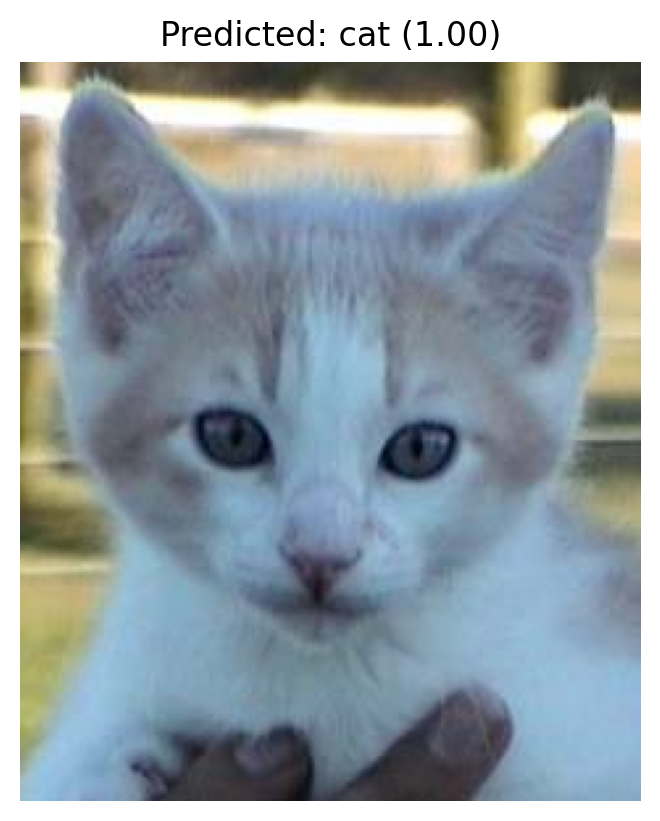

Probability distribution:
cat: 1.00
dog: 0.00
--------------------------------------------------


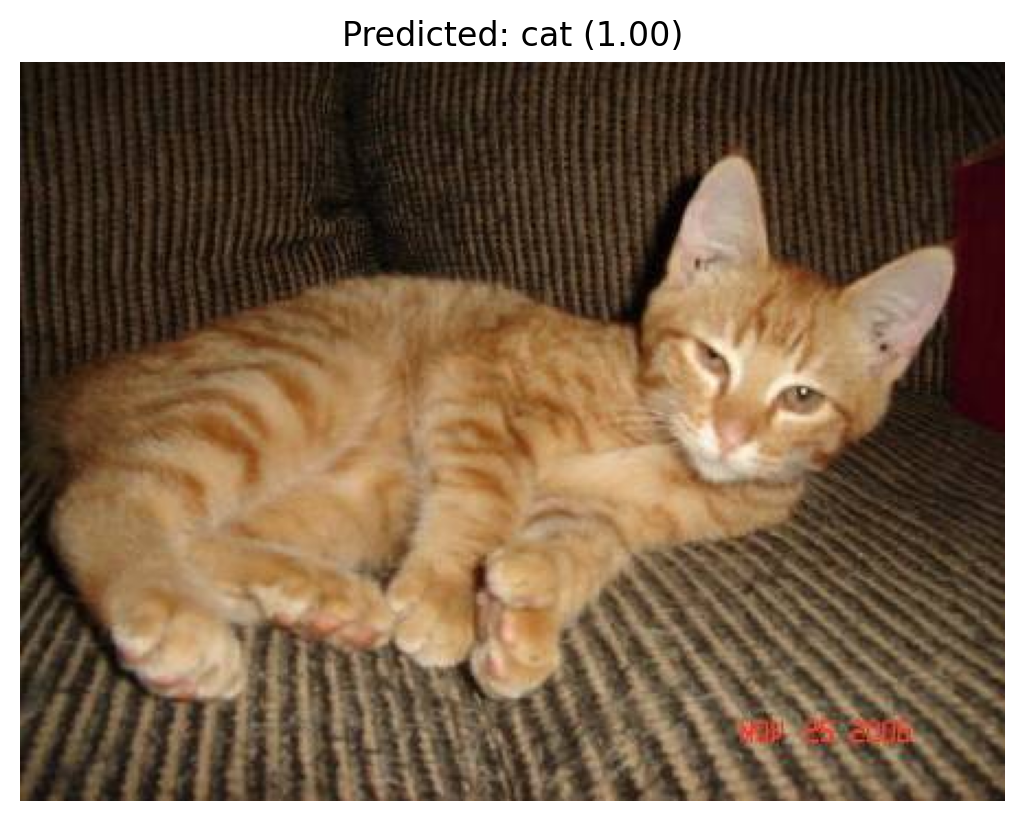

Probability distribution:
cat: 1.00
dog: 0.00
--------------------------------------------------


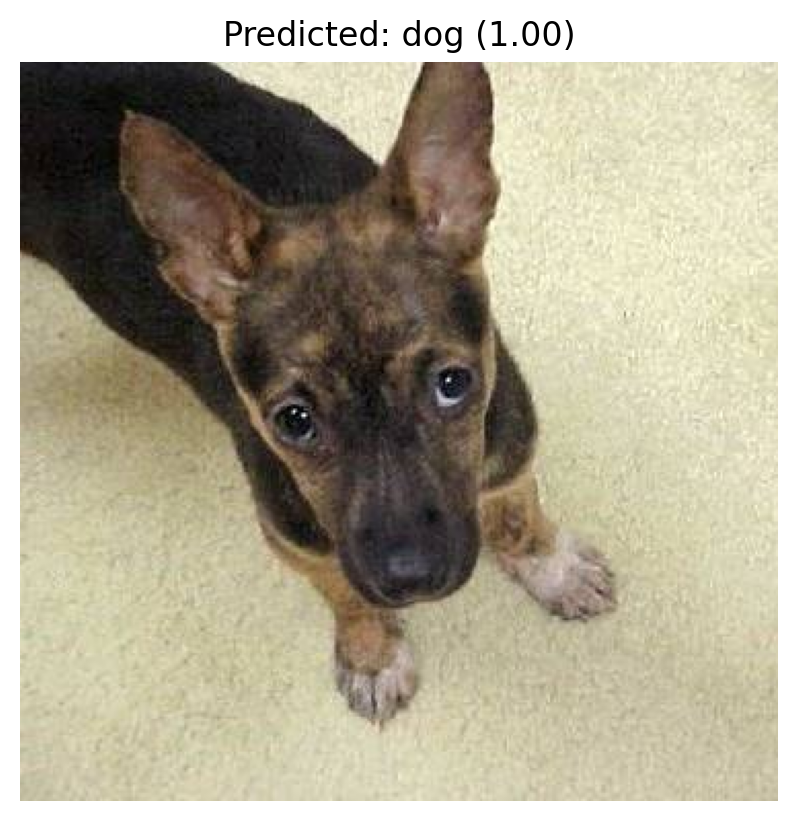

Probability distribution:
cat: 0.00
dog: 1.00
--------------------------------------------------


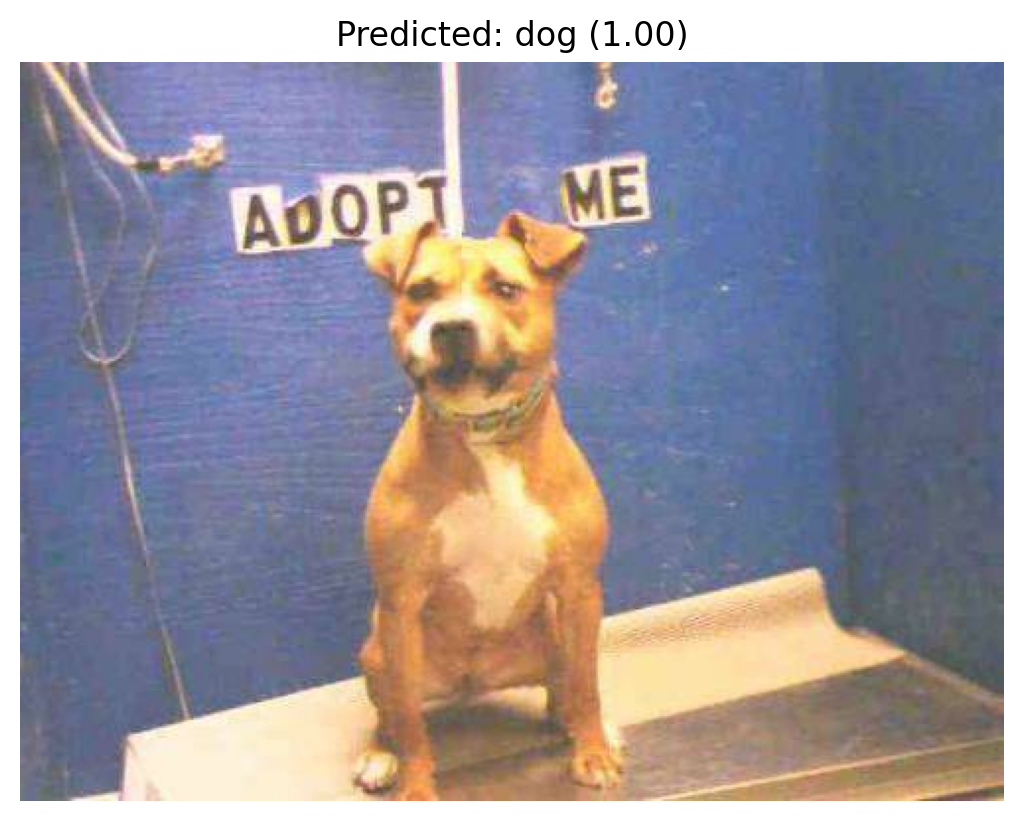

Probability distribution:
cat: 0.00
dog: 1.00
--------------------------------------------------


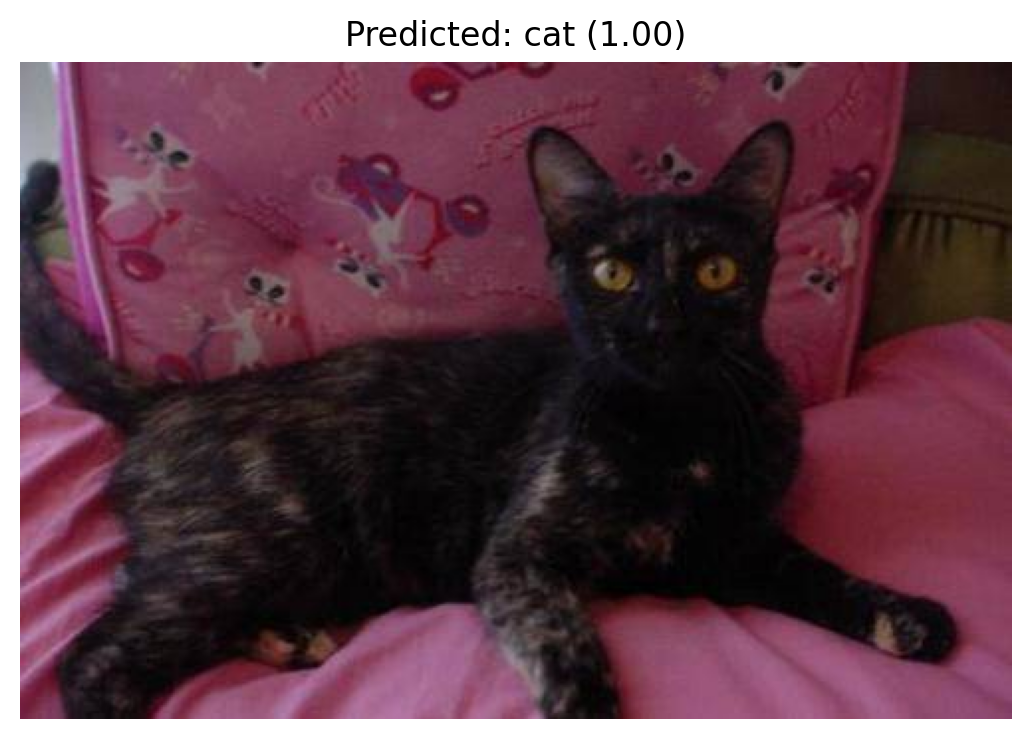

Probability distribution:
cat: 1.00
dog: 0.00
--------------------------------------------------


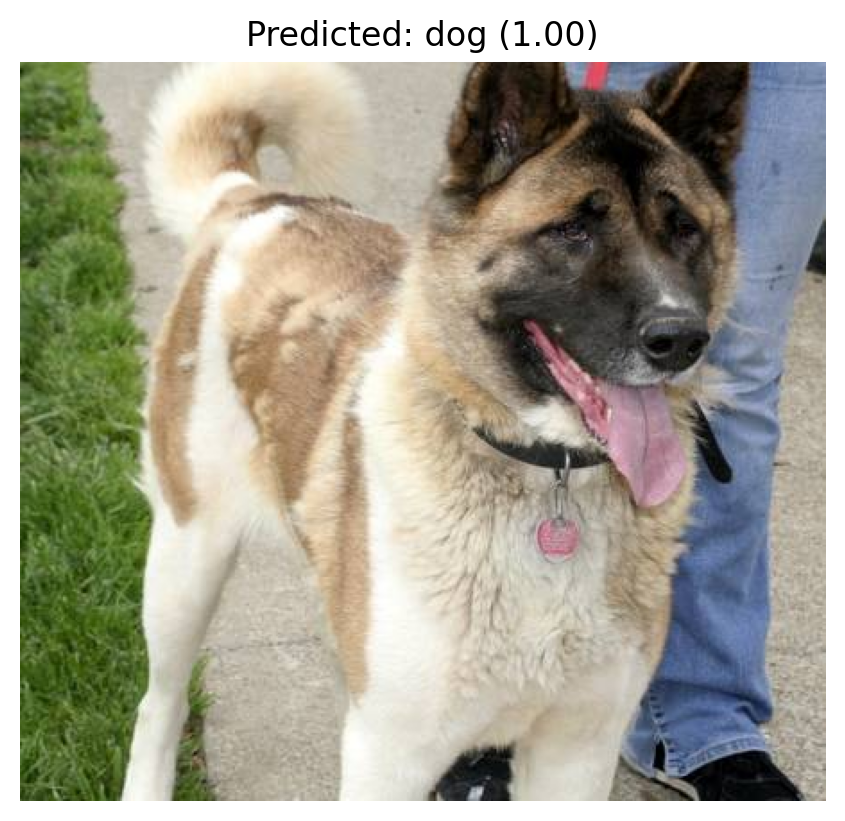

Probability distribution:
cat: 0.00
dog: 1.00
--------------------------------------------------


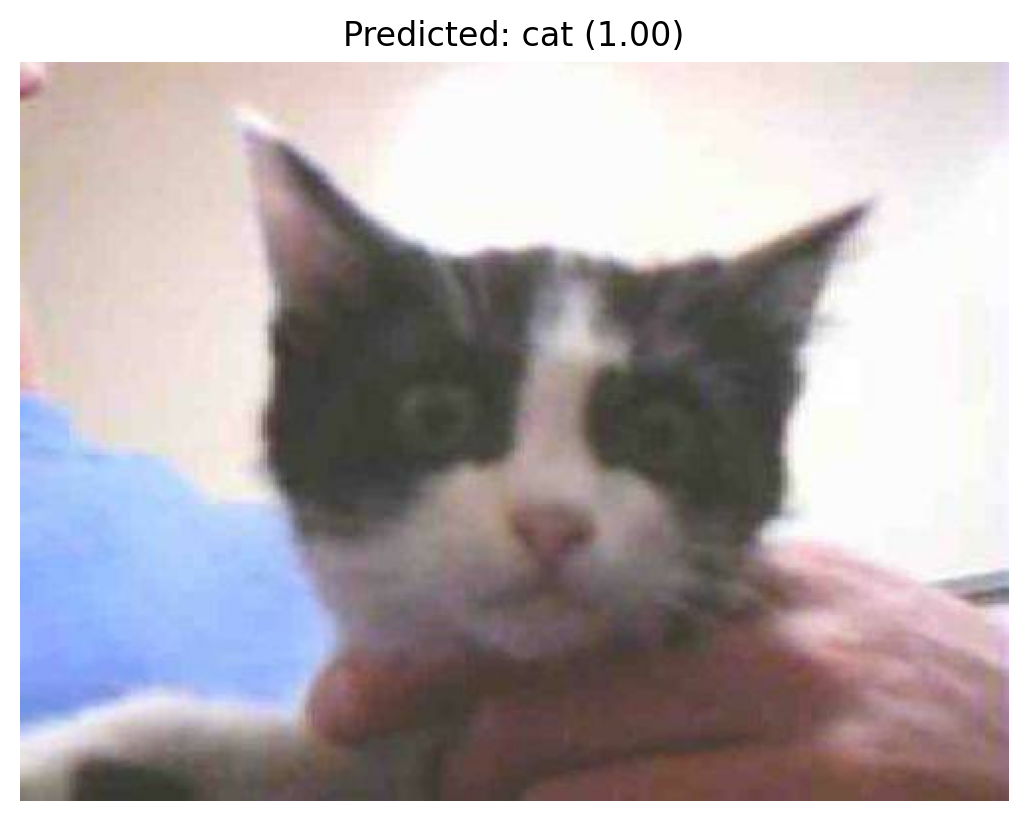

Probability distribution:
cat: 1.00
dog: 0.00
--------------------------------------------------


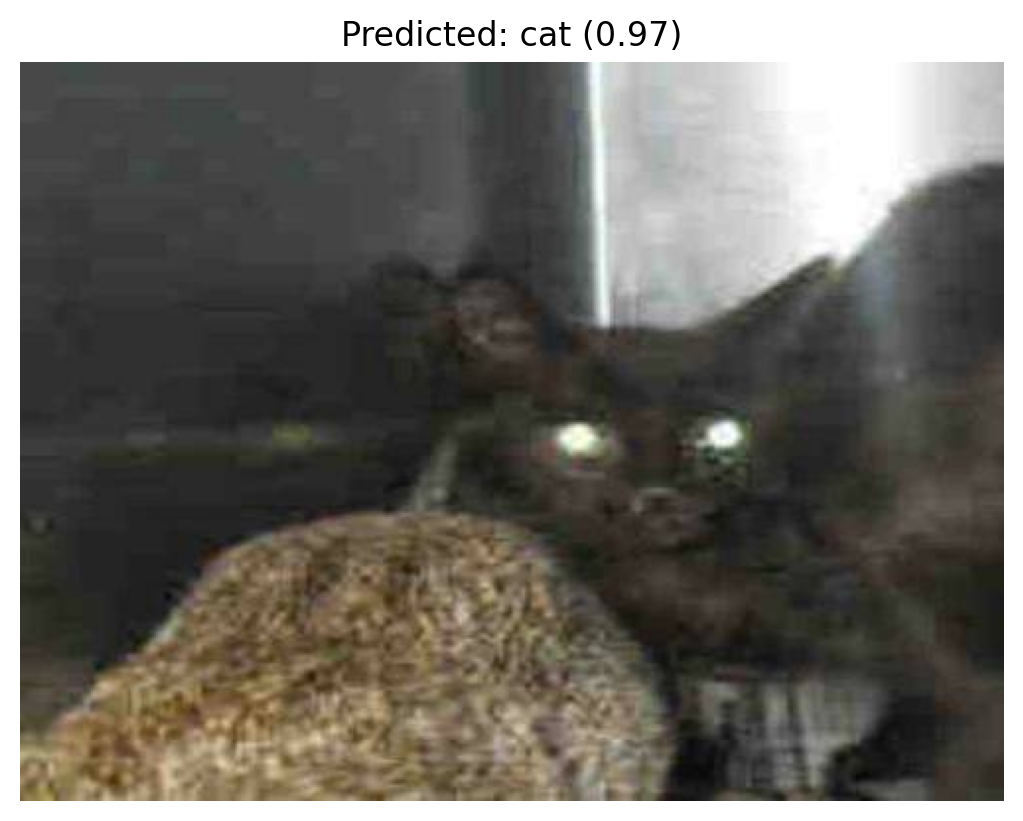

Probability distribution:
cat: 0.97
dog: 0.03
--------------------------------------------------


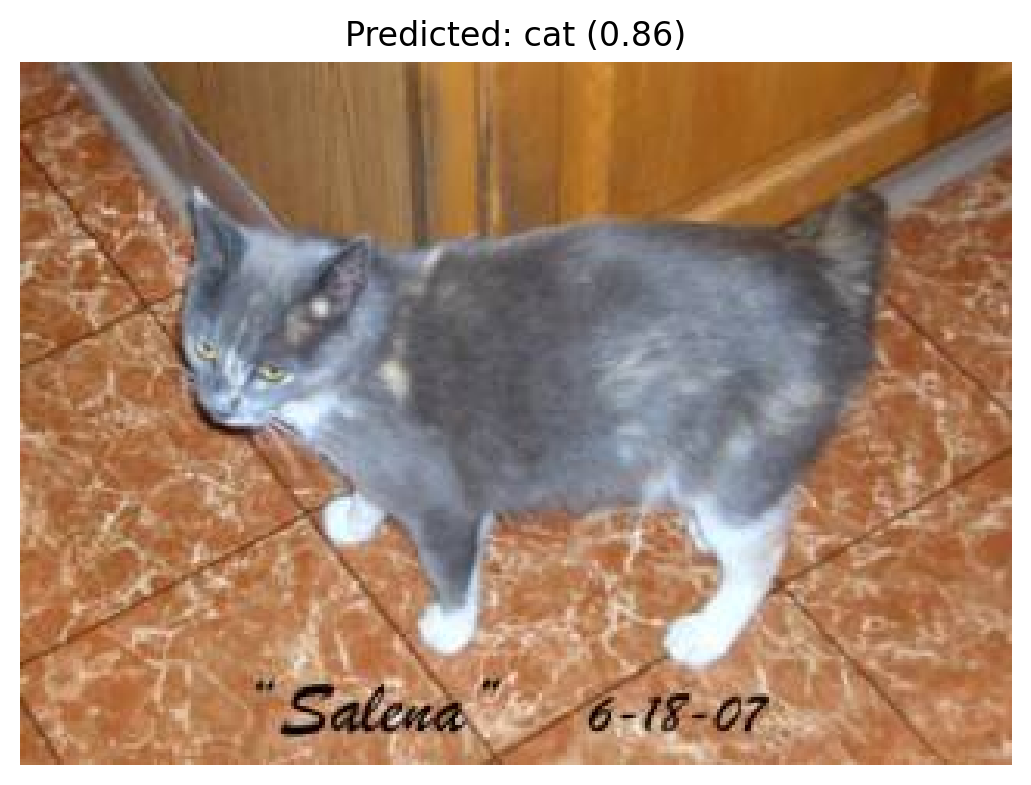

Probability distribution:
cat: 0.86
dog: 0.14
--------------------------------------------------


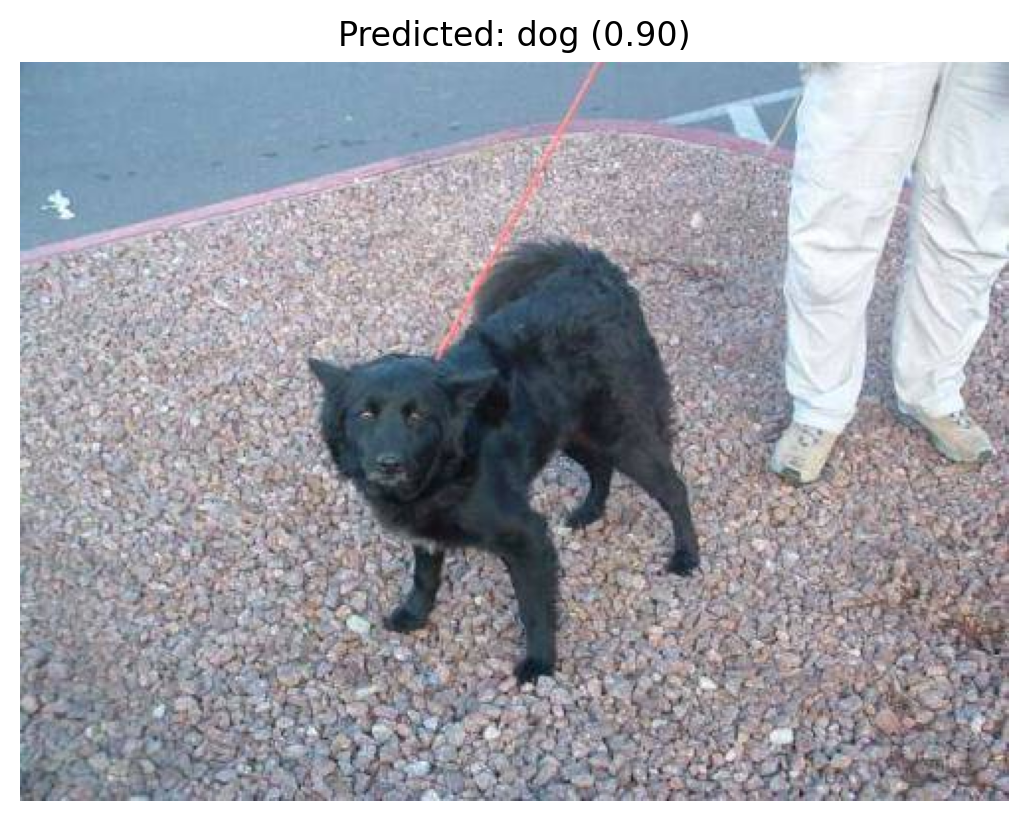

Probability distribution:
cat: 0.10
dog: 0.90
--------------------------------------------------


In [11]:
import torch
import PIL
import matplotlib.pyplot as plt

# Assuming you have defined `test_transforms` and `device` earlier

# Assuming you have a dictionary mapping class indices to their labels
class_labels = train_data.class_to_idx
class_labels = {value: key for key, value in class_labels.items()}

# Get 10 images of cats and dogs from the test dataset
cat_dog_images = [img_path for img_path in os.listdir('/kaggle/working/test')[:10]]
for image_path in cat_dog_images:
    img = PIL.Image.open(os.path.join('/kaggle/working/test', image_path))
    img_tensor = test_transforms(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        log_ps = model(img_tensor)
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)

    # Display the image
    plt.imshow(img)
    plt.axis('off')

    # Get the predicted class label and its probability
    predicted_class_index = top_class.item()
    predicted_class_label = class_labels.get(predicted_class_index)

    # Display the predicted class label and its probability
    plt.title(f"Predicted: {predicted_class_label} ({top_p.item():.2f})")
    plt.show()

    # Print the probability distribution among the two classes
    print("Probability distribution:")
    for i in range(len(ps[0])):
        print(f"{class_labels.get(i, 'Unknown')}: {ps[0][i].item():.2f}")

    print("-" * 50)  # Add a separator between images

In [12]:
df.to_csv("/kaggle/working/submission.csv", index=False)